In [8]:
# 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [9]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(f"Using Pytorch version : {torch.__version__}, Device : {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 10

Using Pytorch version : 1.8.1, Device : cpu


In [10]:
# CIFAR-10 데이터 다운로드 하기 (Train, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR-10",
                                      train = True,
                                      download= True,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(), # 해당 이미지를 50% 확률로 좌우 반전
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              (0.5, 0.5, 0.5), # 평균
                                              (0.5, 0.5, 0.5) #표준편차
                                          )
                                      ]))
test_dataset = datasets.CIFAR10(root = "../data/CIFAR-10",
                                      train = False,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              (0.5, 0.5, 0.5), # 평균
                                              (0.5, 0.5, 0.5) #표준편차
                                          )
                                      ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

Files already downloaded and verified


In [18]:
# 데이터 확인하기 (1)
for (X_train, y_train) in train_loader :
    print(f"X_train : {X_train.size()}, type : {X_train.type()}")
    print(f"y_train : {y_train.size()}, type : {y_train.type()}")
    break

for (X_test, y_test) in test_loader :
    print(f"X_test : {X_test.size()}, type : {X_test.type()}")
    print(f"y_test : {y_test.size()}, type : {y_test.type()}")
    break

X_train : torch.Size([32, 3, 32, 32]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor
X_test : torch.Size([32, 3, 32, 32]), type : torch.FloatTensor
y_test : torch.Size([32]), type : torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

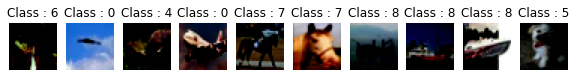

In [12]:
# 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
        # pytorch 에선 [mini_batch, channel, height, width], 시각화 하기 위해서 [width, height, channel]로 변경
    plt.title(f'Class : {str(y_train[i].item())}')

In [13]:
# ResNet 모델 설계하기
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1 ):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1,
                          stride=stride,
                          bias = False),
                nn.BatchNorm2d(planes)
            )

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # feature map의 크기나 channel 수의 변경이 없는 경우 빈 nn.Sequential에 들어가기 때문에 본래 x 가 나온다.
        out = F.relu(out)
        return out

# pooling 을 이용해 feature map 의 사이즈를 줄이는게 아니라 stride로 줄임
# size가 절반이 되면 대신 채널은 2배로
# basic block에서 stride != 1 과 in_planes != plaens 는 여기서는 같은 걸 의미
#   (featrue map의 크기가 절반이 되고 채널이 2배가 되는 경우)
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(
            3, 16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16,2,stride=1)
        self.layer2 = self._make_layer(32,2,stride=2)
        self.layer3 = self._make_layer(64,2,stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides :
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0),-1)
        out = self.linear(out)
        return out

In [14]:
# Optimizer, Objective Function 설정하기
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [15]:
# MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval, epoch) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0 :
            print(f"Train Epoch : {epoch} [{batch_idx*len(image)}/"
                  f"{len(train_loader.dataset)}({100.*batch_idx/len(train_loader):.0f}%)]"
                  f"\tTrain Loss : {loss.item()}")

In [16]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)

            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
# MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200, epoch=Epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH:{Epoch}] \tTest Loss : {test_loss:.4f} \tTest Accuracy : {test_accuracy:.2f}\n")

Train Epoch : 1 [0/50000(0%)]	Train Loss : 2.4760820865631104
Train Epoch : 1 [6400/50000(13%)]	Train Loss : 1.7831093072891235
Train Epoch : 1 [12800/50000(26%)]	Train Loss : 1.3180911540985107
Train Epoch : 1 [19200/50000(38%)]	Train Loss : 1.3241056203842163
Train Epoch : 1 [25600/50000(51%)]	Train Loss : 1.1489046812057495
Train Epoch : 1 [32000/50000(64%)]	Train Loss : 1.1546061038970947
Train Epoch : 1 [38400/50000(77%)]	Train Loss : 1.0795819759368896
Train Epoch : 1 [44800/50000(90%)]	Train Loss : 0.8418883085250854

[EPOCH:1] 	Test Loss : 0.0365 	Test Accuracy : 59.78

Train Epoch : 2 [0/50000(0%)]	Train Loss : 0.7072941660881042
Train Epoch : 2 [6400/50000(13%)]	Train Loss : 1.1547490358352661
Train Epoch : 2 [12800/50000(26%)]	Train Loss : 0.9879781603813171
Train Epoch : 2 [19200/50000(38%)]	Train Loss : 0.8564906120300293
Train Epoch : 2 [25600/50000(51%)]	Train Loss : 1.163549542427063
Train Epoch : 2 [32000/50000(64%)]	Train Loss : 0.9182717204093933
Train Epoch : 2 [384